# Отток клиентов

Из «Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры. Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

In [5]:
# откроем файл
data = pd.read_csv('Churn.csv')

# изучим основную информацию о данных
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Предобработка данных

Видим, что с данными практически всё в порядке. Приведем наименования столбцов к нижнему регистру, данные столбца "Tenure" приведем к целочисленному значению. Проверим данные на наличие явных дубликатов. Видим, что дубликатов нет.

Пропуски есть только в столбце "tenure", 9% от всех строк, в ячейке ниже посмотрим на эти объекты. Видим, что это достаточно активные пользователи банковских услуг. Сложно предположить, связаны ли пропуски с тем, что человек является клиентом банка менее 1 года. Или пропуски появились случайно/в результате технической ошибки и т.п. Корректно заполнить данные пропуски не представляется возможным, поэтому удалим данные строки.

In [6]:
# переименуем названия столбцов - приведем к нижнему регистру
data.columns = data.columns.str.lower()

# проверим датасет на наличие явных дубликатов
data.duplicated().sum()

0

In [7]:
# проанализируем строки с пропусками
data.loc[data['tenure'].isna()].head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


In [8]:
# переведем данные столбца "Tenure" к целочисленному значению и заполним пропуски нулями
data['tenure'] = data['tenure'].astype('Int64')

# удалим пропуски
data = data.dropna(subset=['tenure'])

# проверим результат
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        9091 non-null   int64  
 1   customerid       9091 non-null   int64  
 2   surname          9091 non-null   object 
 3   creditscore      9091 non-null   int64  
 4   geography        9091 non-null   object 
 5   gender           9091 non-null   object 
 6   age              9091 non-null   int64  
 7   tenure           9091 non-null   Int64  
 8   balance          9091 non-null   float64
 9   numofproducts    9091 non-null   int64  
 10  hascrcard        9091 non-null   int64  
 11  isactivemember   9091 non-null   int64  
 12  estimatedsalary  9091 non-null   float64
 13  exited           9091 non-null   int64  
dtypes: Int64(1), float64(2), int64(8), object(3)
memory usage: 1.0+ MB


### Подготовка признаков

В таблице есть несколько столбцов, которые будут мешать модели обучаться - от их значения результат никак не зависит. Это столбцы "RowNumber — индекс строки в данных", "CustomerId — уникальный идентификатор клиента", "Surname — фамилия". Удалим эти столбцы.

In [9]:
# удалим столбцы 'rownumber', 'customerid', 'surname'
df = data.drop(columns = ['rownumber', 'customerid', 'surname'])

# посмотрим на получившуюся таблицу
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Целью нашего исследования является прогноз, уйдёт клиент из банка в ближайшее время (значение целевого признака = 1) или нет (значение целевого признака = 0). Таким образом, нам необходимо решить **задачу классификации**. Для этого обучим 3 вида моделей: решающее дерево, случайный лес, логистическая регрессия. Перед обучением подготовим признаки:
- выполним кодирование категориальных признаков методом OHE для всех типов моделей.
- отмасштабируем численные признаки методом стандартизации - сделаем это после разделения данных на тренировочную, валидационную и тестовую выборки

In [10]:
# кодирование техникой OHE
df_ohe = pd.get_dummies(df, drop_first=True)

Разделим исходные данные на обучающую, валидационную и тестовую выборки. Размеры тестового и валидационного наборов обычно равны. Таким образом, нам необходимо разбить данные в соотношении 3:1:1. Или 60% - обучающая выборка, и по 20% - тестовая и валидационная.

In [11]:
# разделим выборку на 2 части: целевой признак и остальные признаки
features = df_ohe.drop(['exited'], axis=1)
target = df_ohe['exited']

In [12]:
# разделим данные на 2 выборки: 40% тестовая и валидационная вместе взятые, и 60% обучающая
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=0.4, random_state=12345)

# разделим 40% на тестовую и валидационную выборки
features_test, features_valid, target_test, target_valid = \
    train_test_split(features_test, target_test, test_size=0.5, random_state=12345)

# проверим размер получившихся выборок
print(features_train.shape)
print(features_test.shape)
features_valid.shape

(5454, 11)
(1818, 11)


(1819, 11)

In [13]:
# стандартизируем все численные признаки
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.set_option('chained_assignment', None)

## Исследование задачи

### Баланс классов

Проверим датасет на сбалансированность классов в таргете. Видим существенный дисбаланс. В данном разделе обучим модели без учета данного дисбаланса.

In [14]:
# выведем количество строк в разных классах
print('Количество строк, клиент не ушел (класс 0):', df.query('exited == 0').shape[0])
print('Количество строк, клиент ушел (класс 1):', df.query('exited == 1').shape[0])
print('Процент класса "1":', round((df.query('exited == 1').shape[0]) / df.shape[0] * 100))

Количество строк, клиент не ушел (класс 0): 7237
Количество строк, клиент ушел (класс 1): 1854
Процент класса "1": 20


### Дерево решений

Обучим модель "Дерево решений" на обучающей выборке и затем проверим F1-меру на валидационной выборке. Обучим несколько моделей с разной максимальной глубиной дерева и затем выберем наиболее адекватную из них. Чтобы автоматизировать процесс, сделаем это с помощью цикла.

In [15]:
# DecisionTreeClassifier
best_tree = None
best_result = 0
best_depth = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_result:
        best_tree = model
        best_result = f1
        best_depth = depth
print()
print('F1 лучшей модели дерева решений:', best_result.round(5), '. Максимальная глубина дерева:', best_depth)


F1 лучшей модели дерева решений: 0.55348 . Максимальная глубина дерева: 7


In [16]:
# рассчитаем AUC-ROC лучшей модели
model = DecisionTreeClassifier(random_state=12345, max_depth=7)
model.fit(features_train, target_train)

probabilities = model.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
print('AUC-ROC лучшей модели:', roc_auc_score(target_valid, probabilities_one).round(5))

AUC-ROC лучшей модели: 0.82802


### Случайный лес

Обучим модель "Случайный лес" на обучающей выборке и затем проверим F1-меру на валидационной выборке. Обучим несколько моделей с разным количеством деревьев и максимальной глубиной деревьев и затем выберем наиболее адекватную из них. Чтобы автоматизировать процесс, сделаем это с помощью цикла.

In [17]:
# RandomForestClassifier
best_forest = None
best_result = 0
best_est = 0
best_depth = 0

for est in range(10, 51, 10):
    for depth in range(7, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_result:
            best_forest = model
            best_result = f1
            best_est = est
            best_depth = depth
print('F1 лучшей модели случайного леса:', best_result.round(5), '. Количество деревьев:', best_est, '. Максимальная глубина деревьев:', best_depth)

F1 лучшей модели случайного леса: 0.58228 . Количество деревьев: 20 . Максимальная глубина деревьев: 10


In [18]:
# рассчитаем AUC-ROC лучшей модели
model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10)
model.fit(features_train, target_train)

probabilities = model.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
print('AUC-ROC лучшей модели:', roc_auc_score(target_valid, probabilities_one).round(5))

AUC-ROC лучшей модели: 0.85599


### Логистическая регрессия

Обучим модель "Логистическая регрессия" на обучающей выборке и затем проверим F1-меру на валидационной выборке. Попробуем изменить гиперпараметр max_iter (максимальное количество итераций обучения) на значения 100 (по умолчанию), 500, 1000. Видим, что качество модели не меняется, значение F1 остается одинаковым.

In [19]:
# LogisticRegression
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
print('F1 модели логистической регрессии:', f1.round(5))

F1 модели логистической регрессии: 0.3176


In [20]:
# рассчитаем AUC-ROC модели
probabilities = model.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
print('AUC-ROC модели:', roc_auc_score(target_valid, probabilities_one).round(5))

AUC-ROC модели: 0.78094


### Вывод

В данном разделе мы обучили 3 типа моделей на данных с учетом имеющегося дисбаланса - около 20% данных относятся к классу "1" и 80% - к классу "0". Метрика F1 модели логистической регрессии существенно ниже, чем у моделей дерева решений и случайного леса.\
**На валидационной выборке наилучшее качество (F1=0,58) продемонстрировала модель случайного леса с гиперпараметрами: количество деревьев - 20, максимальная глубина деревьев: 10. Площадь ROC-кривой лучшей модели составила 0,86.**

## Борьба с дисбалансом

В первоначальных данных имеется существенный дисбаланс классов - 20%/80%. Для более качественного обучения моделей сбалансируем выборки и попробуем добиться значения F1 выше, чем 0,59. Для этого воспользуемся следующими методами балансировки:
- взвешивание классов;
- увеличение выборки класса "1". Для достижения баланса нам потребуется умножить количество объектов класса "1" на 4;
- уменьшение выборки класса "0". Для достижения баланса нам потребуется умножить количество объектов класса "0" на 0,3.

Для определения качества моделей рассчитаем не только метрику F1, но и построим ROC-кривую.

### Дерево решений

Взвешивание классов:
F1 лучшей модели дерева решений: 0.56536 . Максимальная глубина дерева: 5
AUC-ROC модели: 0.75764


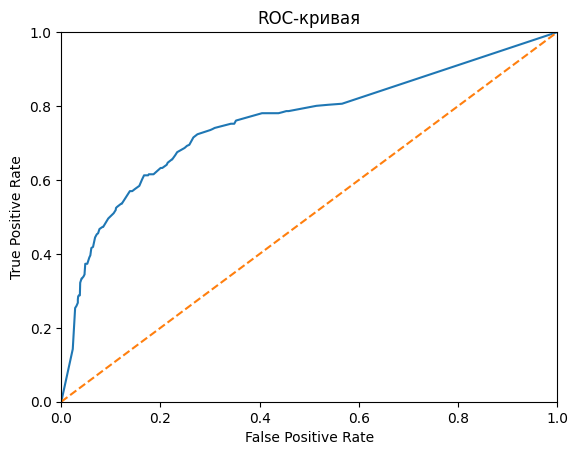

In [21]:
# взвешивание классов

best_tree = None
best_result = 0
best_depth = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_result:
        best_tree = model
        best_result = f1
        best_depth = depth
print('Взвешивание классов:')
print('F1 лучшей модели дерева решений:', best_result.round(5), '. Максимальная глубина дерева:', best_depth)

# рассчитаем AUC-ROC и построим ROC-кривую
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc.round(5))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [22]:
# увеличение выборки

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Увеличение выборки:
F1 лучшей модели дерева решений: 0.56536 . Максимальная глубина дерева: 5
AUC-ROC модели: 0.74891


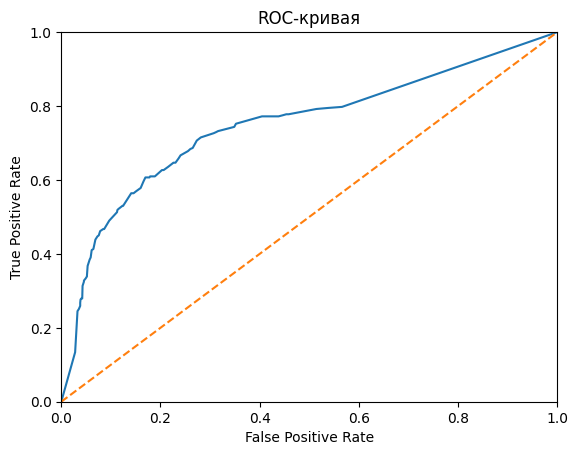

In [23]:
# обучение модели после увеличения выборки

best_tree = None
best_result = 0
best_depth = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_result:
        best_tree = model
        best_result = f1
        best_depth = depth
print('Увеличение выборки:')
print('F1 лучшей модели дерева решений:', best_result.round(5), '. Максимальная глубина дерева:', best_depth)

# рассчитаем AUC-ROC и построим ROC-кривую
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc.round(5))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [24]:
# уменьшение выборки

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

Уменьшение выборки:
F1 лучшей модели дерева решений: 0.56028 . Максимальная глубина дерева: 5
AUC-ROC модели: 0.74544


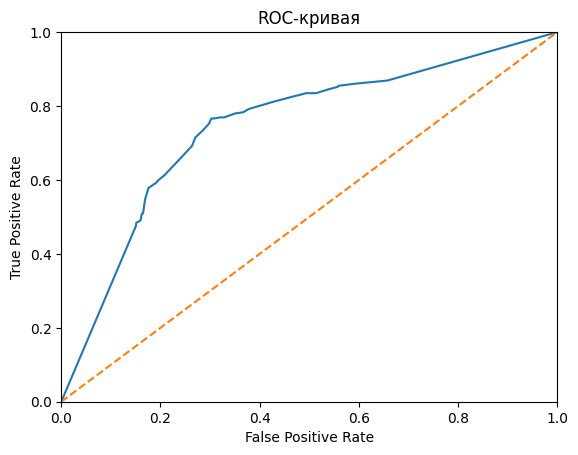

In [25]:
# обучение модели после уменьшения выборки

best_tree = None
best_result = 0
best_depth = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_result:
        best_tree = model
        best_result = f1
        best_depth = depth
print('Уменьшение выборки:')
print('F1 лучшей модели дерева решений:', best_result.round(5), '. Максимальная глубина дерева:', best_depth)

# рассчитаем AUC-ROC и построим ROC-кривую
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc.round(5))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Видим, что борьба с дисбалансом помогает незначительно увеличить значение метрики F1, наибольший эффект дает метод увеличения выборки класса "1". Однако, достичь требуемого уровня F1 не удается.

### Случайный лес

Взвешивание классов:
F1 лучшей модели случайного леса: 0.61642 . Количество деревьев: 20 . Максимальная глубина деревьев: 9
AUC-ROC модели: 0.83385


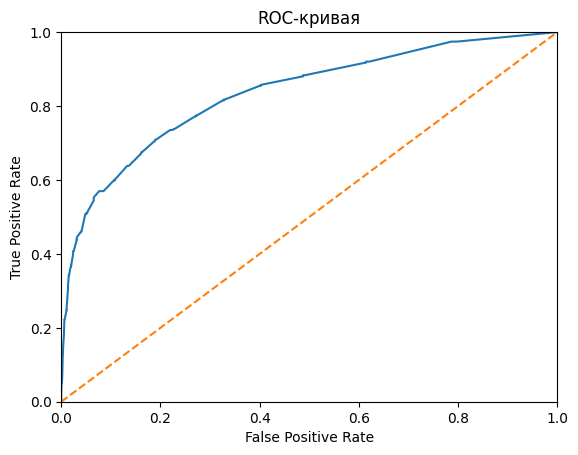

CPU times: user 5.55 s, sys: 115 ms, total: 5.67 s
Wall time: 5.57 s


In [26]:
%%time

# взвешивание классов
best_tree = None
best_result = 0
best_depth = 0

for est in range(10, 31, 10):
    for depth in range(7, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_result:
            best_forest = model
            best_result = f1
            best_est = est
            best_depth = depth
print('Взвешивание классов:')
print('F1 лучшей модели случайного леса:', best_result.round(5), '. Количество деревьев:', best_est, '. Максимальная глубина деревьев:', best_depth)

# рассчитаем AUC-ROC и построим ROC-кривую
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc.round(5))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Увеличение выборки:
F1 лучшей модели случайного леса: 0.61934 . Количество деревьев: 70 . Максимальная глубина деревьев: 18
AUC-ROC модели: 0.84329


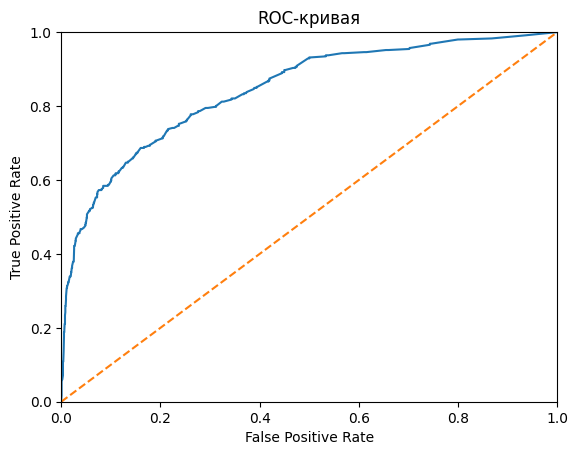

CPU times: user 44.1 s, sys: 198 ms, total: 44.3 s
Wall time: 44.3 s


In [27]:
%%time

# Метод увеличения выборки

best_tree = None
best_result = 0
best_depth = 0

for est in range(10, 81, 10):
    for depth in range(7, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_result:
            best_forest = model
            best_result = f1
            best_est = est
            best_depth = depth

print('Увеличение выборки:')
print('F1 лучшей модели случайного леса:', best_result.round(5), '. Количество деревьев:', best_est, '. Максимальная глубина деревьев:', best_depth)

# рассчитаем AUC-ROC и построим ROC-кривую
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc.round(5))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Уменьшение выборки:
F1 лучшей модели случайного леса: 0.60296 . Количество деревьев: 40 . Максимальная глубина деревьев: 8
AUC-ROC модели: 0.85382


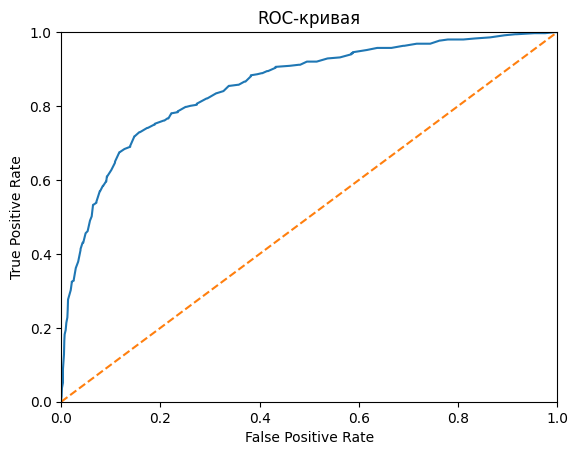

CPU times: user 17.9 s, sys: 164 ms, total: 18 s
Wall time: 18 s


In [28]:
%%time

# метод уменьшения выборки

best_tree = None
best_result = 0
best_depth = 0

for est in range(10, 81, 10):
    for depth in range(7, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_result:
            best_forest = model
            best_result = f1
            best_est = est
            best_depth = depth

print('Уменьшение выборки:')
print('F1 лучшей модели случайного леса:', best_result.round(5), '. Количество деревьев:', best_est, '. Максимальная глубина деревьев:', best_depth)

# рассчитаем AUC-ROC и построим ROC-кривую
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc.round(5))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Модели случайного леса показывают существенное улучшение метрики F1 после устранения дисбаланса. Все они достигли требуемого порога F1 > 0,59.
Наилучший результат (F1 = 0,62) дает метод увеличения выборки класса "1", модель случайного дерева с гиперпараметрами: количество деревьев: 70, максимальная глубина деревьев: 18.

### Логистическая регрессия

Взвешивание классов:
F1 модели логистической регрессии: 0.50254
AUC-ROC модели: 0.78176


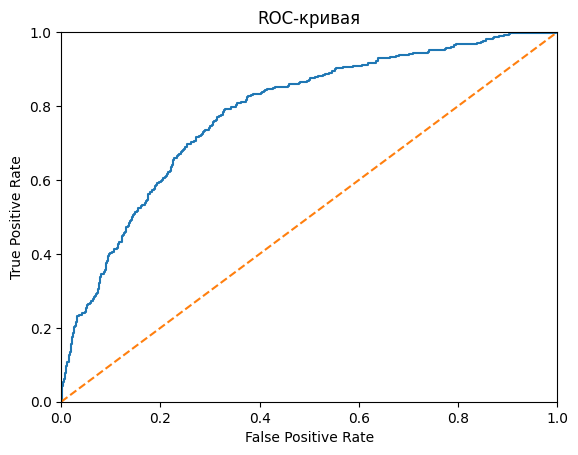

In [29]:
# взвешивание классов
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
print('Взвешивание классов:')
print('F1 модели логистической регрессии:', f1.round(5))

# рассчитаем AUC-ROC и построим ROC-кривую
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc.round(5))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Увеличение выборки:
F1: 0.49654
AUC-ROC модели: 0.78173


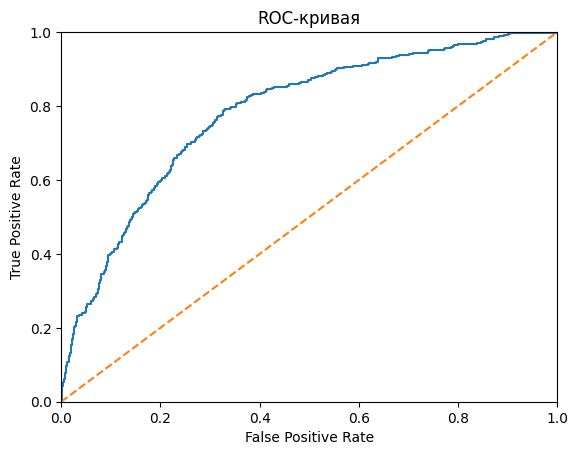

In [30]:
# Увеличение выборки

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print('Увеличение выборки:')
print("F1:", f1_score(target_valid, predicted_valid).round(5))

# рассчитаем AUC-ROC и построим ROC-кривую
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc.round(5))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Уменьшение выборки:
F1: 0.48749
AUC-ROC модели: 0.7808


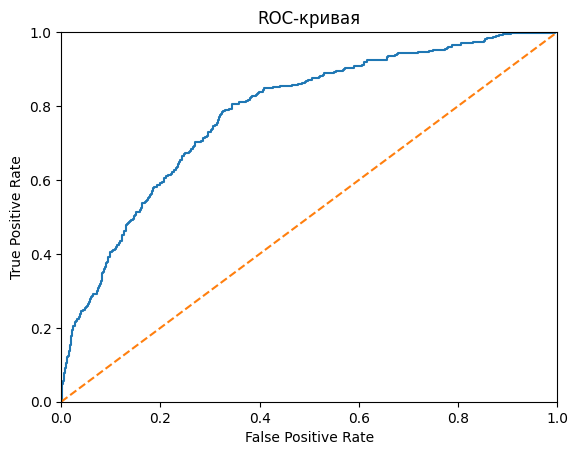

In [31]:
# уменьшение выборки

model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print('Уменьшение выборки:')
print("F1:", f1_score(target_valid, predicted_valid).round(5))

# рассчитаем AUC-ROC и построим ROC-кривую
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc.round(5))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Видим, что борьба с дисбалансом помогает существенно увеличить значение метрики F1 у моделей логистической регрессии, наибольший эффект дает метод взвешивания классов. Однако, достичь требуемого уровня F1 не удается.

### Вывод

В данном разделе мы сбалансировали данные разными методами и после этого обучили модели. Метрика F1 моделей логистической регрессии существенно ниже, чем у моделей дерева решений и случайного леса.\
**На валидационной выборке наилучшее качество (F1=0,62) продемонстрировала модель случайного леса с гиперпараметрами: количество деревьев - 70, максимальная глубина деревьев: 18.** Проверим лучшую модель на тестовой выборке.

## Тестирование модели

Проверим найденную нами лучшую модель на тестовой выборке.

F1: 0.62059
Полнота (recall): 0.55968
AUC-ROC модели: 0.85524


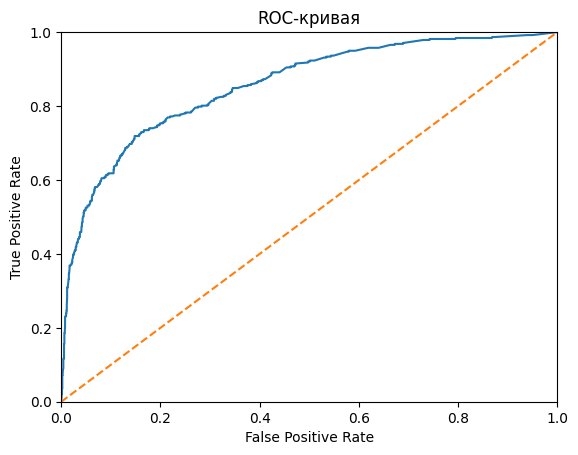

In [32]:
# обучим модель и проверим ее на тестовой выборке
model = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=18)
model.fit(features_upsampled, target_upsampled)
predictions_test = model.predict(features_test)

f1 = f1_score(target_test, predictions_test)
recall = recall_score(target_test, predictions_test)
print('F1:', f1.round(5))
print('Полнота (recall):', recall.round(5))

# рассчитаем AUC-ROC и построим ROC-кривую
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC модели:', auc_roc.round(5))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Вывод:**\
Выбранная нами модель показывает хороший результат на тестовой выборке - значение F1 меры равно 0,62, что выше заданного порогового уровня 0,59. Значение AUC-ROC равно 0,85.

Отдельно была рассчитана метрика полнота (recall), ее значение составило 0,56. Это говорит о том, что модель правильно определяет 56% тех клиентов, которые действительно уйдут/планируют уйти.

### Проверка модели на адекватность

Чтобы оценить адекватность модели, сравним её результаты с константной моделью. Заменим все предсказания на "1" и рассчитаем F1.

In [33]:
# расчет F1 константной модели
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
predictions_dummy = dummy_model.predict(features_test)
f1 = f1_score(predictions_dummy, target_test)
print('F1 константной модели:', f1.round(5))

F1 константной модели: 0.34351


## Итоговый вывод

- в данном проекте были исследованы 3 модели: дерево решений, случайный лес и логистическая регрессия;
- изначально в датасете наблюдался существенный дисбаланс классов - 20% / 80%. Все модели показали наивысшее качество после устранения дисбаланса;
- наибольшее значение F1-меры показала модель случайного леса после устранения дисбаланса методом увеличения выборки класса "1" с гиперпараметрами: количество деревьев - 70, максимальная глубина деревьев: 18;
- лучшая модель была проверена на тестовой выборке и показала значение F1-меры в размере 0,62, AUC-ROC в размере 0,85. Отдельно была рассчитана полнота (recall), ее значение составило 0,56. Это говорит о том, что модель правильно определяет 56% среди тех клиентов, которые действительно уйдут/планируют уйти.

С помощью модели мы можем спрогнозировать, уйдет ли клиент из банка. Маркетологи посчитали, что сохранять текущих клиентов дешевле, чем привлекать новых.
Полученный с помощью прогноза результат мы можем использовать для определения перечня текущих клиентов, которые по мнению модели должны уйти из банка. Этим клиентам банк может заранее предложить более выгодные условия, премиальное обслуживание или провести среди них опрос и выяснить уровень лояльности и проблемные точки, почему клиент может быть не доволен услугами банка.